# Object detection

In this assignment I am going to implement R-CNN from scratch in Keras using Airplane data-set from http://www.escience.cn/people/JunweiHan/NWPU-RESISC45.html.

## Procedure

1. Image preprocessing and preparation
2. Running selective search algorithm to obtain 2000 most interesting regions
3. From those 2000 regions obtain 30 (sub)images that have the highest IoU (positive cases) and 30 that have the lowest IoU
4. Using a pretrained model VGG16 trained on ImageNet and apply/fit the model to our problem
5. Use the final model to predict bounding box areas of test images

In [1]:
# Connect to google drive via google colab libraby

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/Documents/Personal/Education/FRI/Masters/1.Letnik/1.Semester/SB/IBB-project-2/

/content/drive/MyDrive/Documents/Personal/Education/FRI/Masters/1.Letnik/1.Semester/SB/IBB-project-2


### 1. Image processing and preparation

The main file for image preprocessing is **`preprocessing/preprocessing.ipynb`**.

1. We perform selective search algorithm and add obtained "interested" regions to np array (matrix).

2. Here we load the saved **X** matrix and **y** labels for further processing

In [3]:
import numpy as np

In [4]:
X_train = np.load('preprocessing/X_new.npy')
y_train = np.load('preprocessing/y_new.npy')

### 2. Object detection



In [5]:
import keras
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [6]:
# Load model VGG16 with pre-trained weights from imagenet
model = VGG16(weights='imagenet', include_top=True)

# Make model untrainable execpt last two layers
for layers in (model.layers)[:15]:
    layers.trainable = False

X = model.layers[-2].output
predictions = Dense(2, activation="softmax")(X)

model_final = Model(inputs = model.input, outputs = predictions)

model_final.compile(
          loss = keras.losses.categorical_crossentropy, 
          optimizer = Adam(learning_rate=0.0001), 
          metrics=["accuracy"]
)

553476096/553467096 [==============================] - 7s 0us/step


In [7]:
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
def binarize_labels(x):
    return np.array([[1, 0] if i == 1 else [0, 1] for i in x])

In [9]:
# Binarize y array
y_train = binarize_labels(y_train)

In [10]:
print(X_train.shape, y_train.shape)

(13108, 224, 224, 3) (13108, 2)


In [13]:
checkpoint = ModelCheckpoint("my_detector.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

### Fitting the model

In [14]:
hist = model_final.fit(
        X_train, 
        y_train, 
        steps_per_epoch= 10, 
        epochs= 10, 
        batch_size=128, 
        verbose = 1, 
        validation_split=.05, 
        shuffle = True, 
        callbacks=[checkpoint,early]
)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.1473 - accuracy: 0.9430
Epoch 00001: val_loss improved from inf to 0.24080, saving model to my_detector.h5
10/10 [==============================] - 27s 3s/step - loss: 0.1473 - accuracy: 0.9430 - val_loss: 0.2408 - val_accuracy: 0.9268
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.1591 - accuracy: 0.9414
Epoch 00002: val_loss improved from 0.24080 to 0.20730, saving model to my_detector.h5
10/10 [==============================] - 38s 4s/step - loss: 0.1591 - accuracy: 0.9414 - val_loss: 0.2073 - val_accuracy: 0.9146
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.1378 - accuracy: 0.9508
Epoch 00003: val_loss improved from 0.20730 to 0.18689, saving model to my_detector.h5
10/10 [==============================] - 34s 4s/step - loss: 0.1378 - accuracy: 0.9508 - val_loss: 0.1869 - val_accuracy: 0.9253
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.1288

In [15]:
import matplotlib.pyplot as plt

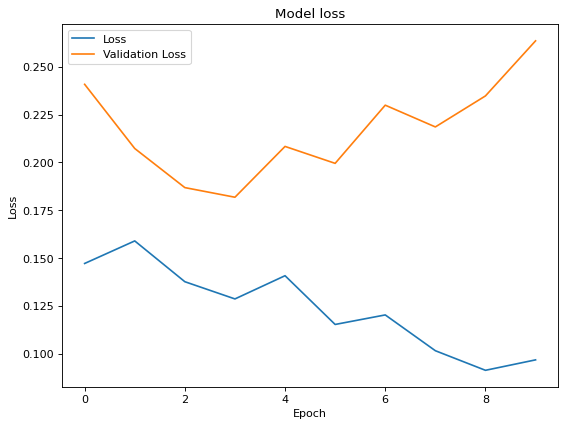

In [19]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.savefig('metrics/model_loss.png')
plt.show()